# Mini-Project 1: Logistic Regression and SVM
**Group 5:** Jeff Nguyen, William Hinton, Adam Ruthford  
**06JUN2020**

# Create Models


This notebook seeks to explore how logistic regression and SVM/SGD can classify the success or failure of small business administration loans.  This notebook utilizes PCA, scaling, piplining, undersampling, hyperparameter tunning as strategies to optimize model performance.  A discussion of model performance and interpretation is included as well.

## Initial Data Cleaning and Preparation

Initial data cleaning and preparation code was derived from **Project 1**, where data types and null values were addressed.  Data were first imported into a pandas dataframe, followed by each feature getting set to the appropriate data type based on data dictionary definitions.  For example, features that have currencies are set to the float data type as they are a continuous feature; whereas features like **NewExist** is categorical in nature and set to the object data type.

In [1]:
#Import data manipulation, vizulization, and ML Packages
import pandas as pd

#load data into pandas dataframe
loans = loans = pd.read_csv('C:/Users/Jeff/Desktop/ML1/SBAnational.csv')


C:\Users\Jeff\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**DisbursementGross**, **BalanceGross**, **ChgOffPrinGr**, **GrAppv**, **SBA_Appv** are features that deal with currency and are coded as strings which include '$' and ',' characters. Used this website for help with [converting currency to float.](
https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas)

To treat these features as continuous data the special characters were removed, and the data was converted to the float data type.  This will allow for the data to be used by methods that utilize continous data.  **ApprovalDate**, **ChgOffDate**, and **DisbursementDate** are features that contain dates and were converted to the date/time data type.  This will be usefull for potential time series analysis.  **NewExist** is a categorical feature but has a float data type.  This feature was converted to an integer data type since float is better suited for continuous data.  **Zip**, **NAICS**, **FranchiseCode** are nominal features, but will be converted to strings for ease of manipulation and data cleaning.

In [2]:
import numpy as np

# Create lists of features that need their data types converted
currency = ['DisbursementGross','BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv']
date = ['ApprovalDate','ChgOffDate','DisbursementDate']
cat_variables = ['Zip']

# Convert features to appropriate data types
loans[currency] = loans[currency].replace('[\$,]', '', regex=True).astype(float)
loans[date]= loans[date].astype(np.datetime64)
loans['NewExist'] = loans['NewExist'].astype('Int64')
loans[cat_variables] = loans[cat_variables].astype(str)

Several null values were also present in the City and State features. City contained 14 null values and State contained 30 null values. Both features describe the loan applicant's address information. For City null values, zip codes from the Zip feature and the United States Postal Service Zip Code Lookup tool (https://tools.usps.com/zip-code-lookup.htm?citybyzipcode) were used to identify the correct city or state name. Two zip-codes in City feature and two zip-codes in the State feature did not return a city in the United States and were left as 'NaN'. Since there are only 4 rows of data that do not have proper city or state data, they will be kept or removed depending on the machine learning algorithm used.

In [3]:
# Replace City NA with appropriate state/city name
cityList = ['Salt Lake City','New Orleans','Chicago','Chicago','San Diego','San Diego','San Diego','San Diego',
            'San Diego','San Diego','Clevland','St. Louis','St. Louis','St. Louis','St. Louis','St. Louis',
            'St. Louis','Seattle','Des Moines','San Antonio','Kansas City','Kansas City','Quincy','Quincy','Boston',
            'NaN','NaN','Louisville','Wilmington','Flint']
stateList = ['NaN','NaN','CA','AP','KS','TX','FL','WI','NJ','UT','MO','TX','TX','TX']

#Replace Cities with NAs with appropriate City or State    
loans.loc[loans.City.isnull(),'City'] = cityList
loans.loc[loans.State.isnull(),'State'] = stateList

A new feature called **difference_in_days** was created by subtracting ApprovalDate minus DisbursementDate.  This will explain the relationship between time the loan was approved to disburment date. There may be some correlation to why a loan is defaulted on depending on disbursement date.

In [4]:
#Create new Time feature and convert to int
from datetime import datetime, timedelta
d1 = loans.DisbursementDate
d2 = loans.ApprovalDate
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%Y")
    d2 = datetime.strptime(d2, "%d-%m-%Y")
    return abs((d2 - d1).days)

difference_in_days = abs((d2-d1))/ timedelta(days=1)

loans['difference_in_days'] = difference_in_days

Addressing 1997 null records for MIS_Status was unique in that it was depedent on several attributes in the dataset. There were four different combinations of code used to address the null records for this feature. The first combination identified null values that had a non-null value in the ChgOffDate feature and that the ChgOffPrinGr feature was not equal to zero; this combination of conditional requirements identified records that defaulted and had a charge off balance and renamed the null values as "CHGOFF". The second combination identified null values where DisbursementDate was not null and the BalanceGross was equal to zero; this combination of features identifies records that did not receive funds and do not have a balance, this labeled the null values as "P I F". The third and fourth combination identify null MIS_Status records where funds were not disbursed by checking DisbursementGross and BalanceGross features. If the DisbursementGross was zero or null and the BalanceGross was 0, the missing data was labels as "Not Disbursed".


In [5]:
#--------------------------------------------------------------------------------------------------------------------
#Fill In NaN fields
loans.dropna(subset = ['Name'], inplace = True)
loans["Bank"].fillna("Not Listed", inplace = True) 
loans["BankState"].fillna("Not Listed", inplace = True) 
loans['NewExist'].fillna(0, inplace = True)
loans['RevLineCr'].fillna("Not Provided", inplace = True)
loans['LowDoc'].fillna("Not Provided", inplace = True)
loans['ChgOffDate'].fillna("0000-00-00",inplace = True)
loans['DisbursementDate'].fillna("0000-00-00",inplace = True)

#Replace NaT MIS_status with CHGOFF if their ChgOffDate is not null
#If MIS_Status has value, 
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) & 
                         ((loans['ChgOffDate'].notnull()) |
                          (loans['ChgOffPrinGr']!=0.0)),'CHGOFF',inplace=True) 

loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementDate'].notnull()) & 
                         (loans['BalanceGross']==0.0),'P I F',inplace=True)

loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementGross'].isnull()) & 
                         (loans['BalanceGross']==0.0),'Not Disbursed',inplace=True)

loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementGross']==0.0) & 
                         (loans['BalanceGross']==0.0),'Not Disbursed',inplace=True)

#--------------------------------------------------------------------------------------------------------------------
loans['MIS_Status'].replace(to_replace = 'P I F', value = 1, inplace = True)
loans['MIS_Status'].replace(to_replace = 'CHGOFF', value = 0, inplace = True)

After null values were removed, the index was reset for the loans data frame.  When rows are removed from a data frame, the index for that row remains.  If the indcies are not reset, null values will be assigned to indicies that had rows removed. Since sklearn algorithms require matricies and arrays, when a data frame with surplus incies are converted to a matrix, there will be a shape mismatch causing an error.  The .info() function was run to check on null values and the range index.

In [6]:
loans = loans.dropna()#drops 14 records
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [7]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896782 entries, 0 to 896781
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       896782 non-null  int64         
 1   Name                896782 non-null  object        
 2   City                896782 non-null  object        
 3   State               896782 non-null  object        
 4   Zip                 896782 non-null  object        
 5   Bank                896782 non-null  object        
 6   BankState           896782 non-null  object        
 7   NAICS               896782 non-null  int64         
 8   ApprovalDate        896782 non-null  datetime64[ns]
 9   ApprovalFY          896782 non-null  object        
 10  Term                896782 non-null  int64         
 11  NoEmp               896782 non-null  int64         
 12  NewExist            896782 non-null  Int64         
 13  CreateJob           896782 no

## Response and Explanatory Feature Descriptions, and Feature Engineering

### Response Feature

Three features in the SBAnational dataset can serve as response variables.  Two are continuous and one is categorical.  These features were choosen to be response variables as they are good indicators of loan success or failure.

**CreateJob and RetainedJob:** These columns are presented as an integer. The column records the number of jobs created or retained, respectively. These variables cannot be used as explanatory variables as they indicate the success of the loan. They are a proxy for loan success. However, these variables can be used as the response variable in a model that would attempt to maximize job creation and or retention. Thus, any of these response terms correlated with explanatory terms are significant and noteworthy due to their possible predictive power.  Since we are more interested in the classification of accounts having paid in full or were charged off; these featuers will be exclued from the model.

**MIS_Status:** This column is presented as an object/string. The column is categorical data with values "P I F" and "CHGOFF". This column is the main response column of the dataset.  This feature will be used to determine if a loan has succeeded or failed, where 'P I F' is a success, and a 'CHGOFF' is a failure.  Approximately 18% of loans were marked for a 'CHGOFF' and 82% successful repaid their loans.  This feature will serve as the response feature for our logistic and SVM models as it is dichotmous and indicates weither or not a loan applicant has paid their loan back or not.  **MIS_Status** will also be converted to numeric values instead of character for use in the model.

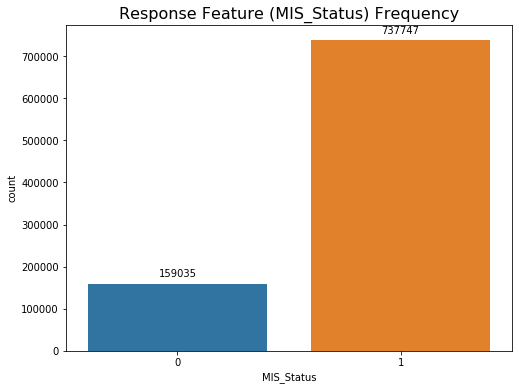

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.countplot(x =loans['MIS_Status'] )
plt.title("Response Feature (MIS_Status) Frequency",fontsize= 16)

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

### Explanatory Features

**ApprovalDate**, **DisbursementDate**, and **ChgOffDate** are features that contain dates.  Since there are a large volume of dates, these features would not be suited for conversion to categorical features unless they were binned.  **ApprovalFY** is similar to **ApprovalDate** and may better be suited for use in the model; this feature can be binned to reduce the number of levels in the feature. This model does not address time series analysis or autocorrelation structures.  If a record contains a value from **ChgOffDate**, then the loan defaulted.  This information is more sussenctly captured in the **MIS_Status** level 'CHGOFF'; due to the redundancy **ChgOffDate** would be more useful in a new feature that captures a time difference with another time feild.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant. **SBA_Appv** will be kept, while **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.  Please see the correlation matrix in the **Data Preparation** section for more details.

**LoannNr_ChkDgt** is the primary key for this dataset.  There are large removed. 
**Name** remove – there was no need to know the name of the loan applicate or business.
**City** remove - how this might be useful we decided that there is no need to have city due to loans can originate from different cities where the applicant works and uses the loan. 
**Zip** remove – it is ideal to have the zip code of where the loan originated so we can see where the demographics of most loans are generated but that is not part of this exercise, so we got rid of the zip. 
**BankState** remove – this is not good to use because well known banks will be in most popular area and not the rural area. The demographic is skewed as we have identified in the bank state demographic graph. 
**ChgOffDate** remove – once a loan has defaulted, there is a charge off date. We are not using it. 
**Term** keep – this is a good indicator to determine if the loan will be defaulted due to the terms, some loans have short terms and most of them have long terms. 
**NoEmp** keep – this is the number of employees generated from the loan.  
**FranchiseCode** keep – this indicates what type of businesses are requesting loans and which ones are likely to pay back the loan.  
**BalanceGross** keep – this variable indicates how much needs to be repaid. Larger loan might have large balances if they are not paid back quickly.  


### Feature Engineering

**State**, **Bank**, **NAICS**, **ApprovalFY, **NewExist**, **UrbanRural**, **RevlineCr**, and **LowDoc** are features that require binning and/or one-hot-encoding.  These features may require additional cleaning and may have many categories.  Consolidating the number of categories can assist with reducing overfitting and reduce the computational load it would take to find weights for the numerous levels that exist in some of the features.

#### Categorical Features

**Bank** contains over 5,803 unique levels.  Using this many levels in a model may lead to overfitting.  To avoid this situation the large volume of banks will be reduced by consolidating and binning into nine bins.  These bins will contain the top eight banks, and an 'other' category containing the other smaller banks.  The other category was created by renaming all banks that were not in the 'major_banks' list to 'other'.  The .describe() function was then run on the modified feature to confirm that the correct number of categories were created.

In [9]:
loans['Bank'].value_counts()

BANK OF AMERICA NATL ASSOC        86498
WELLS FARGO BANK NATL ASSOC       63371
JPMORGAN CHASE BANK NATL ASSOC    47730
U.S. BANK NATIONAL ASSOCIATION    35068
CITIZENS BANK NATL ASSOC          34861
                                  ...  
FDIC/2277 JACKSON MS                  1
FDIC/UNIIVERSITY BANK                 1
NORTHWEST FARM CR. SERV ACA           1
STATE BANK OF MISSOURI                1
FDIC/TEXAS BK & TR CO                 1
Name: Bank, Length: 5799, dtype: int64

In [10]:
loans['Bank'].value_counts().head(15)

BANK OF AMERICA NATL ASSOC        86498
WELLS FARGO BANK NATL ASSOC       63371
JPMORGAN CHASE BANK NATL ASSOC    47730
U.S. BANK NATIONAL ASSOCIATION    35068
CITIZENS BANK NATL ASSOC          34861
PNC BANK, NATIONAL ASSOCIATION    27285
BBCN BANK                         22887
CAPITAL ONE NATL ASSOC            22244
MANUFACTURERS & TRADERS TR CO     11246
READYCAP LENDING, LLC             10656
THE HUNTINGTON NATIONAL BANK       9587
KEYBANK NATIONAL ASSOCIATION       9249
TD BANK, NATIONAL ASSOCIATION      8982
BRANCH BK. & TR CO                 8251
ZIONS FIRST NATIONAL BANK          7943
Name: Bank, dtype: int64

In [11]:
# Banks create buckets for top 19 banks + other
major_bank = ['BANK OF AMERICA NATL ASSOC', 'WELLS FARGO BANK NATL ASSOC',
              'JPMORGAN CHASE BANK NATL ASSOC','U.S. BANK NATIONAL ASSOCIATION',
              'CITIZENS BANK NATL ASSOC','PNC BANK, NATIONAL ASSOCIATION',
             'BBCN BANK','CAPITAL ONE NATL ASSOC']

loans.loc[~loans["Bank"].isin(major_bank), "Bank"] = "Other"

A barchart was also created for the modified **Bank** to visually confirm that there are eight major banks followed by an 'other' category.  We can see that the Bank of America is one of the larger banks by loan applicaiton volume followed by Wells Fargo.  However, many loans are aquired through other banks, perhaps many of them local.  A for loop was applied to show the frequencies of loans that the banks have per bin.

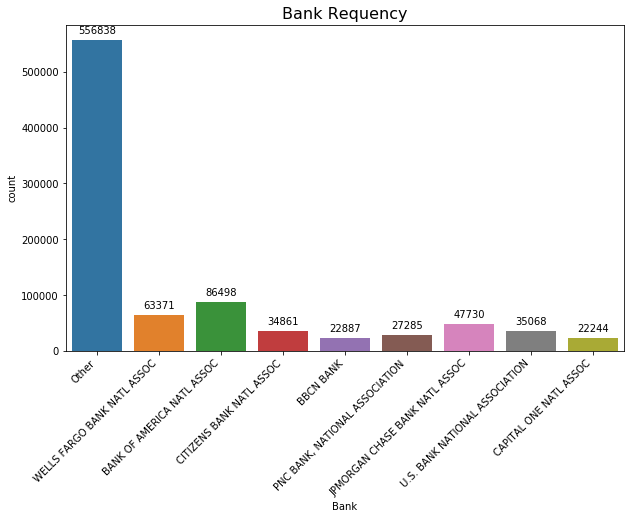

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['Bank'] )
plt.title("Bank Requency",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:#provides frequency counts
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

The North American Industry Classification System (**NAICS**) is used to classify a business into 19+ sectors that specialize in different services.  To reduce the number of levels, sectors were grouped based on similar attributes. The list of sectors can be viewed in the 'Data Dictionary' section of this link:https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied?select=SBAnational.csv 

Sectors were grouped by the first digit in their code as seen below:
- 1 Agriculture
- 2 Mining, Utilities, Construction
- 3 Manufacturing
- 4 Trade and Transportation
- 5 Professional and Scientific
- 6 Education and Health
- 7 Arts and Hospitality
- 8 other
- 9 Public Administration


In [13]:
# create NAICS bins for 0,1,2,3,4,5,6,7,8,9
'NAICS'
loans['NAICS'].replace(to_replace = 0, value = 800000, inplace = True)
loans['NAICS']= pd.cut(loans['NAICS'],
                       [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000],
                       labels = ['1','2','3','4','5','6','7','8','9'])

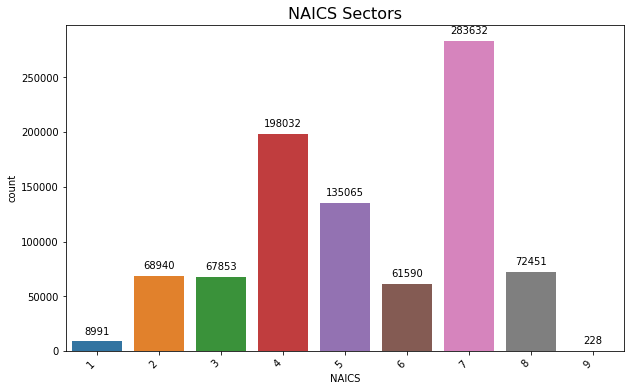

In [14]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['NAICS'] )
plt.title("NAICS Sectors",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**ApprovalFY** has values from 1962 to 2014, with several values coded 1976A in an object format.  Since there is a large range of values and characters present in some of the values, 1976A will be converted to 1976, followed binning values by decade.  This will result in 5 bins.  We can see that after preforming the binning, the 2000-2010 bucket has the most values at 509174 loan applications.  The .describe funtion was run to confirm that the correct number of categories were created, followed by a barchart for visual inspection.  Many loan applications occured during the 2000-2010 decade, followed by the 1990-2000 decade.

In [15]:
# Create ApprovalFY buckets spread by decade, 1976A need to be cleaned
loans['ApprovalFY'].replace(to_replace = '1976A', value = '1976', inplace = True)
loans['ApprovalFY'] = loans['ApprovalFY'].astype(int)
loans['ApprovalFY_decade']= pd.cut(loans['ApprovalFY'],[1970,1980,1990,2000,2010,2020])
loans['ApprovalFY_decade'].describe()

count           896769
unique               5
top       (2000, 2010]
freq            507649
Name: ApprovalFY_decade, dtype: object

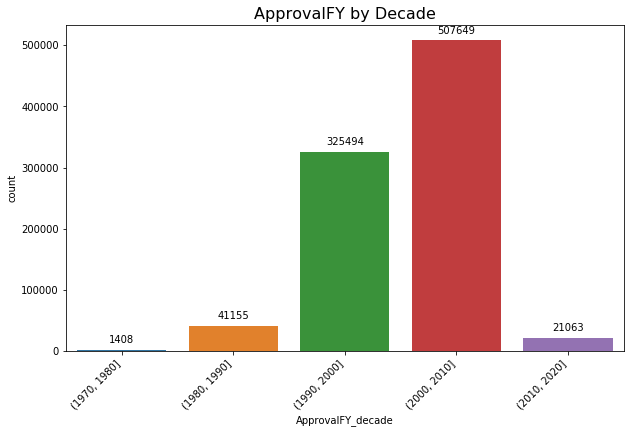

In [16]:
#Bucket ApprovalFY by decade
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['ApprovalFY_decade'] )
plt.title("ApprovalFY by Decade",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**RevLineCr**, or Revolving Line of Credit should have values coded "Y" or "N".  We can see that there are 18 categories when there should be two.  All values coded "0" were converted to "N"; all values with "1" were coded to "Y", and all character values were coded as "N".  A plot below confirms that after cleaning that there are two classes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

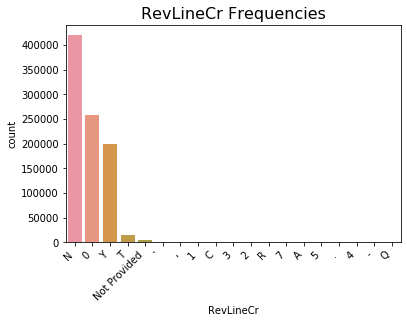

In [17]:
# RevLineCredit: delete special characters 14 total, recode numbers to letters
ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

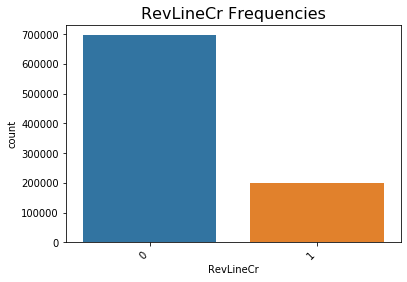

In [18]:
loans['RevLineCr'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['RevLineCr'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['T','`','Not Provided',",",'C','3','2','R','7','A','5','.','4',"'",'Q','-']
loans['RevLineCr'].replace(to_replace = no, value = 0, inplace = True)

ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**LowDoc** has 9 categories when it should have 3.  All values with "Y" will be coded as 1; values with "N" will be coded as 0; all other values will be coded as 0.  We can see that most loan applicants are not part of the LowDoc loan program in the barchart below.  After reorganization we can see that there are 2 categories with 0 being the largest with 788,817 records.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

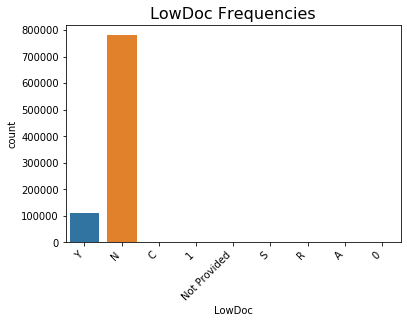

In [19]:
# LowDoc: covert everything to Y or N
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

In [20]:
loans['LowDoc'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['LowDoc'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['C','S','Not Provided','S','R','A']
loans['LowDoc'].replace(to_replace = no, value = 0, inplace = True)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

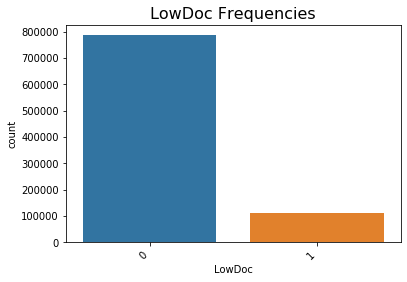

In [21]:
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**FRANCHISE CODE** is a feature that describes if a business is a franchise or not and id denoted with '0' being no, and '1' being yes.  All records that were not coded as '0' were recoded to '1'.  Some examples of this would be records with 'Y', which would then be recoded to '1'.  The plot below confirms the cleaning and that two classes remain.

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(array([0, 1]), <a list of 2 Text xticklabel objects>)

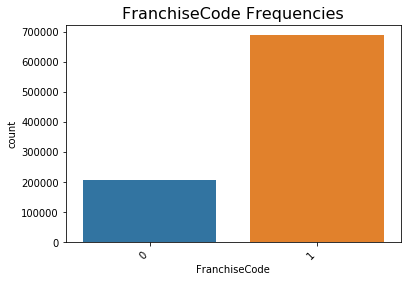

In [22]:
loans['FranchiseCode'].loc[(loans['FranchiseCode'] !=0)] = 1

ax = sns.countplot(x =loans['FranchiseCode'] )
plt.title("FranchiseCode Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

There are over 50 categories for the **State** feature, where each category is a state or military address.  If all the states were converted via one-hot-encoding, or dummy coding, there would be a risk of overfitting.  To address this states will be grouped into the following regions: West, Midwest, Southwest, Southeast, and Northeast.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 <a list of 53 Text xticklabel objects>)

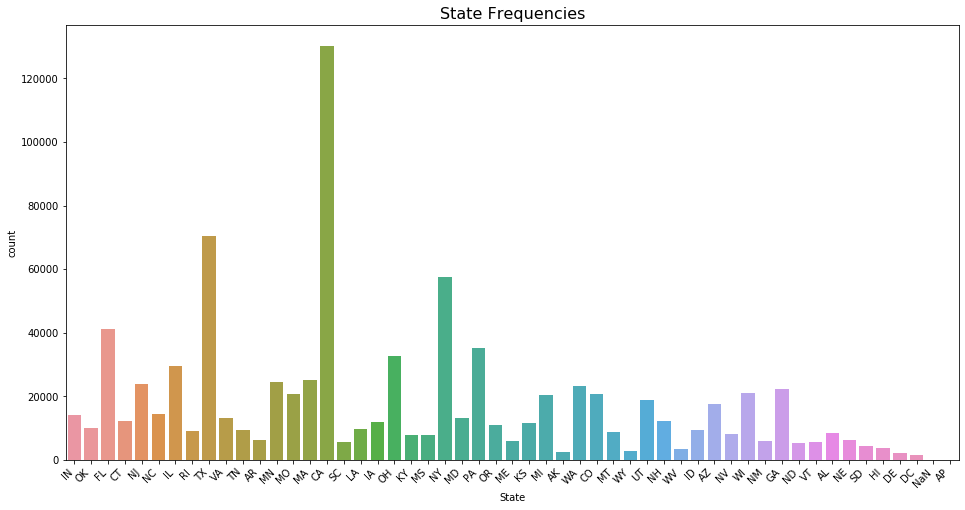

In [23]:
# State Distribution
plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("State Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

After the **State** feature was binned by region, we can see that the 'West' has the most loan applocations, followed by the 'Northeast' and 'Midwest'.  The code below assigns each state to a region based on this map found on National Geographic:https://www.nationalgeographic.org/maps/united-states-regions/

The binning was confirmed by a barchart to ensure that all states were properly assigned to a region.  The barchart include frequency counts for ease of reading and was generated using a for loop.

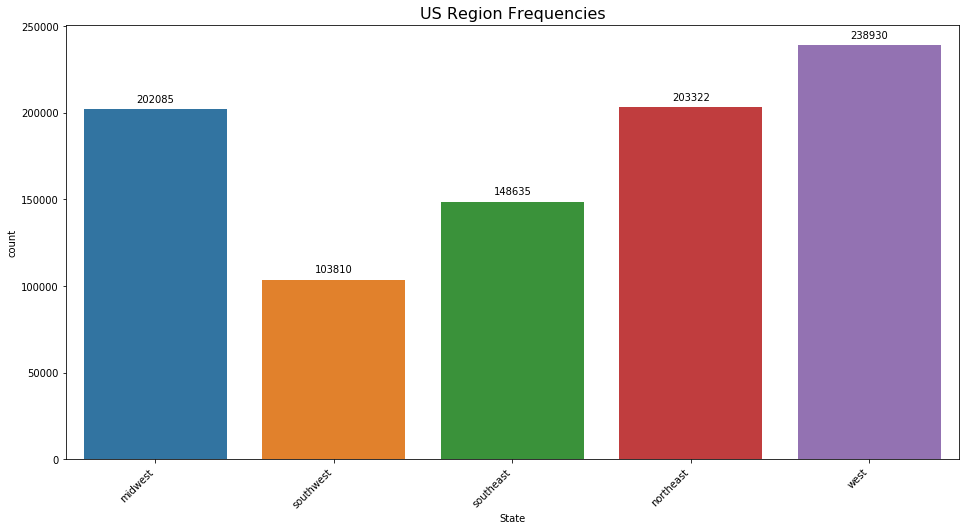

In [24]:
#Generate list of states
west = ['WA','OR','CA','NV','UT','CO','WY','MT','ID','AK','HI','AP','NaN']
midwest =['ND','SD','NE','KS','MO','IA','MN','MI','IL','IN','OH','WI']
southeast = ['AR','LA','MS','TN','KY','WV','VA','NC','SC','GA','FL','AL']
southwest = ['AZ','TX','NM','OK']
northeast = ['ME','VT','NH','CT','RI','NY','NJ','DE','MD','MA','PA','DC']

loans['State'].replace(to_replace = west, value = 'west', inplace = True)
loans['State'].replace(to_replace = midwest, value = 'midwest', inplace = True)
loans['State'].replace(to_replace = southeast, value = 'southeast', inplace = True)
loans['State'].replace(to_replace = southwest, value = 'southwest', inplace = True)
loans['State'].replace(to_replace = northeast, value = 'northeast', inplace = True)

plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("US Region Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

#### Categorical One-hot-encoding

**Bank**, **NAICS**, **ApprovalFY_decade**, **UrbanRural**, **NewExist**, and **State** are nominal categorical features and are best represented by one-hot-encoding or as an integer.  For our models, these features will be converted to on hot encoding and the old feature will be removed.  After one-hot-encoding was complete, the .info() function was run to visually check to ensure that the function created new features and removed the old features.  Failure to remove features used to create on-hot-encoded features would introduce multicollinearity.  This property would result in an over-inflation of model metrics.

In [25]:
loans = pd.get_dummies(loans,columns=['Bank','NAICS','ApprovalFY_decade',
                                      'UrbanRural','NewExist','State'])

#Clean up dataset
'Bank','NAICS','ApprovalFY_decade'
if 'Bank' in loans:
    del loans['Bank']
    
if 'NAICS' in loans:    
    del loans['NAICS']
    
if 'ApprovalFY' in loans:    
    del loans['ApprovalFY']
    
if 'State' in loans:    
    del loans['State']  

if 'UrbanRural' in loans:    
    del loans['UrbanRural']  
        
if 'NewExist' in loans:    
    del loans['NewExist']  

In [26]:
loans = loans.dropna()#drops 14 records
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [27]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896782 entries, 0 to 896781
Data columns (total 56 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   LoanNr_ChkDgt                        896782 non-null  int64         
 1   Name                                 896782 non-null  object        
 2   City                                 896782 non-null  object        
 3   Zip                                  896782 non-null  object        
 4   BankState                            896782 non-null  object        
 5   ApprovalDate                         896782 non-null  datetime64[ns]
 6   Term                                 896782 non-null  int64         
 7   NoEmp                                896782 non-null  int64         
 8   CreateJob                            896782 non-null  int64         
 9   RetainedJob                          896782 non-null  int64         
 

After additional cleaning and binning of the categorical features we can see that the number of unique levels has decreased.  Having fewer levels per features should reduce the computational load and potential overfitting when running our classification algorithms.

### Quantitative Features

The correlation matrix below shows continuous features that help determine if a loan is paid in full or if it defaults.  The correlation matrix shows that **DisbursementGross** is strongly and positively with **SBA_Appr** and **GrAppv**; and **SBA_Appr** is strongly and positively correlated with **GrAppv**. **NoEmp** and **Term** feature show moderate or low correlation compared to the remaining features. **DisbursementGross**, **SBA_Appr** and **GrAppv** all relate to the amount of money a small business is approved for or received and the correlation matrix shows how strongly correlated those values are. It is most likely that values from DisbursementGross, **SBA_Appr** and **GrAppv** are the same or are very close to each other.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant.  Since the **SBA_Appv** feature describes the amount of money that is approved and guaranteed to an applicant it will be kept.  **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.

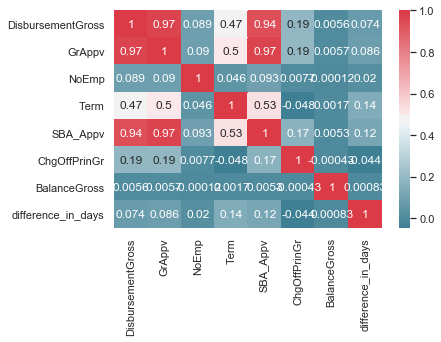

In [28]:
normal_data =['DisbursementGross', 'GrAppv', 'NoEmp', 'Term', 'SBA_Appv','ChgOffPrinGr', 
              'BalanceGross','BankState','difference_in_days']
loans_corr = loans[normal_data]

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

#Generate a correlation matrix of transformed data
sns.set(style="darkgrid") # one of the many styles to plot using
sns.heatmap(loans_corr.corr(), cmap=cmap, annot=True)

#### PCA Features

An alternative to removing highly correlated continuous features is to preform principal component analysis on all continious features, keeping the principal components that explain most of the variation in the continuous data, and removing the features that were used to create the principal components.


In [29]:
from sklearn.preprocessing import StandardScaler #standardizes data
from sklearn.preprocessing import LabelEncoder # converts categories to int

pca_data = ['NoEmp','Term','DisbursementGross','GrAppv','SBA_Appv','difference_in_days']
pca_df = loans[pca_data]

# Standardize continuous data
df_scaled = pd.DataFrame(StandardScaler().fit_transform(pca_df),columns = pca_df.columns)

#Check that data frame is complete
df_scaled.head()

,NoEmp,Term,DisbursementGross,GrAppv,SBA_Appv,difference_in_days
0,-0.099985,-0.340615,-0.491416,-0.469020,-0.444992,3.277715
1,-0.126939,-0.644810,-0.560919,-0.539596,-0.515010,-0.116814
2,-0.059555,0.876162,0.297435,0.332007,0.286922,1.021790
3,-0.126939,-0.644810,-0.578294,-0.557239,-0.532515,0.042803
4,0.034783,1.636648,0.095878,0.127339,0.347094,-0.207264


The scree plot reveals that the first two principal components explain most of the variation in the continous data.  These two principal components are contained in the "X_pca" data frame and will be appended to the **loans** data frame, while **NoEmp**, **Term**, **DisbursementGross**, **ChgOffPrinGr**, **GrAppv**, **'difference_in_days'**, and **SBA_Appv** will be removed.  This version of the **loans** data will be used to test and compare a logistic model/svm with highly correlated continuous features removed, and a logistic/svm model that utilizes prinicpal components.

Text(0.5, 1.0, 'PCA Scree Plot')

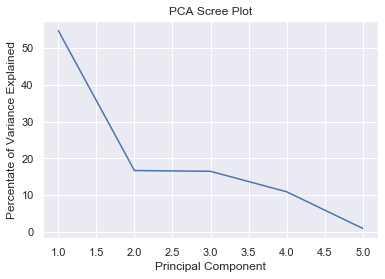

In [30]:
from sklearn.decomposition import PCA
#run PCA
pca = PCA(n_components=5)
X_pca = pca.fit(df_scaled).transform(df_scaled)

#Scree Plot
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
plt.plot(range(1,6),percent_variance)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')

In [31]:
#Run PCA on continuous features
pca = PCA(n_components=2)
X_sm_pca2 = pca.fit_transform(df_scaled)

#Isolate 1st 2 principal components as indicated in scree plot
prin_com = pd.DataFrame(X_sm_pca2)
prin_com = prin_com.rename(columns={0: "PC1", 1: "PC2"})

## Initial Logisitic Model

The loans dataframe was split into a target dataframe and the explanatory feature space.  For the logistic and SVM models the 'MIS_Status' feature will serve as the target, while the remaining features will serve as the feature space.  As models are refined, multiple new feature spaces will be created by elminating highly correlated explanatory features, adding principal components, adding new engineered features, or removing features that do not have weights that contribute a large weight to the models.

In [32]:
# Create feature space and target non PCA data
y = loans['MIS_Status'].values
explanatory = loans.drop(['MIS_Status','LoanNr_ChkDgt','Name','City','Zip','BankState',
                          'ApprovalDate','ChgOffDate', 'DisbursementDate',
                          'DisbursementGross','ChgOffPrinGr', 'GrAppv', 'CreateJob',
                          'RetainedJob','BalanceGross'],axis = 1) 
X = explanatory.values

A cross_validate() helper function was adapted from Dr. Jake Drew's stratified_cross_validate() helper Function found in the following notebook https://github.com/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb.

The cross_validate() helper function takes model, feature_names, the feature space, the target, scaling, cv, and classifier type arguments.  This function generates several iterations of a model specified by the cv object, then averages the preformance metrics and the weights between each iteration. 

The helper function outputs accuracy, precision, f1-score, and recell preformance metrics and a feature weight plot.  The output generated from the helper funciton can help judge model preformance.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
import time

# Set test/train split to 80/20
cv = ShuffleSplit(n_splits = 5, train_size  = 0.8, random_state=42)

#helper function preforms cross validation and generates model preformance metrics
def cross_validate(model,feature_names, X, y, scale = False, classifier = 0, cv=cv):
    acc, pre, f1, recall, weights = ([] for i in range(5))
        
    start = time.time()
    for iter_num, (train_indices, test_indices) in enumerate(cv.split(X,y)):
        
        model.fit(X[train_indices],y[train_indices])  # train object
        y_hat = model.predict(X[test_indices]) # get test set precitions
        
        #present iteration model metrics
        print("====Iteration",iter_num + 1," ====")
        print("f1-score", mt.f1_score(y[test_indices],y_hat))
        print("\nconfusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        
        #append iteration model metrics for later averaging
        f1.append(mt.f1_score(y[test_indices],y_hat))
        elapsed_time = (time.time() - start)
        
        if scale == True:
            weights.append(model.named_steps[classifier].coef_)#logit_model
        else:
            weights.append(model.coef_)
        print()
    #Take average of CV metrics
    print('--------------------------------')
    print('Mean f1-score:', np.array(f1).mean())
    print('CV Time: ', elapsed_time)
        
    mean_feature_weights = np.mean(np.array(weights), axis = 0)
    
    w = pd.Series(mean_feature_weights[0],index=feature_names)
    plt.figure(figsize=(10,6))
    w.plot(kind='bar')
    plt.show()
    return

### Baseline Logistic Preformance

The inital logistic model utilizing the raw data shows that the **Term** feature weight dominates the other features.  This shows that **Term** is highly correlated with the reponse. This is due to the large range of values that **Term** has, with a range of 0 months to 569 months.  

The f1-score was over 90%.  However, upon inspection of the confusion matrix, the true negative cell is severly underrepresented.  When looking at the "Response and Explanatory Feature Descriptions, and Feature Engineering" section, "charge-offs" should be approximately 17% of the response.  

The confusion matricies for the intial unscaled data shows that the "charge-off" minority class is less than 1% of the true values; this model currently is good at predicting loans that are "paid in full" but has difficulty detecting "charge-offs."  In attempt to improve the model, data was scaled to keep all data within the same dynamic range, and under sampling of the magority class was preformed to have the "charge-off" response better represented.

====Iteration 1  ====
f1-score 0.9015691956149512

confusion matrix
 [[    53  31776]
 [   359 147169]]

====Iteration 2  ====
f1-score 0.9012920244985247

confusion matrix
 [[    55  31862]
 [   355 147085]]

====Iteration 3  ====
f1-score 0.9018326571231724

confusion matrix
 [[    40  31689]
 [   370 147258]]

====Iteration 4  ====
f1-score 0.902291268079896

confusion matrix
 [[    60  31585]
 [   334 147378]]

====Iteration 5  ====
f1-score 0.9020944123491034

confusion matrix
 [[    52  31671]
 [   308 147326]]

--------------------------------
Mean f1-score: 0.9018159115331296
CV Time:  20.344286918640137


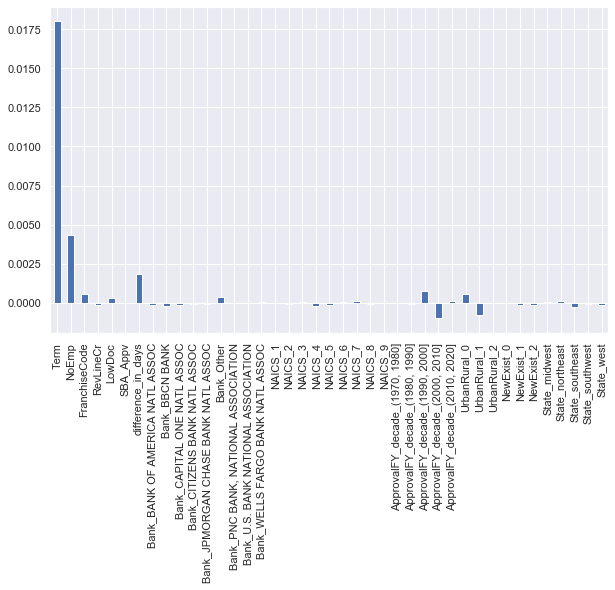

In [34]:
#run inital model
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', random_state=42)
# Raw Data

cross_validate(lr_clf,explanatory.columns, X, y,scale =False)

Before scaling the data, the majority class for the response ("P I F") was undersampled to allow for better representation of the minority "CHGOFF" class. Doing so will allow for a model to better predict for both classes in the target feature. When we look at the confusion matrix of the inital logistic model with no transformations or sampling, the minorty class was barely detected compared to the majority class.

Under-sampling was preformed using the RandomUnderSampler() function set to the majority class. After data was under sampled, continuous data was scaled using the StandardScaler(), which was then fed in to the Pipeline() function. This allows for data to be scaled with a model and reduce the volume of code to generate a similar result.

The metrics for the model were lower than that of the intial model. However, both the "paid-in-full" and "charge-off" classes are both equally represented by the logistic model. The f1-score after cross validation using a 80 train/20 was 76%. While these values are lower compared to the inital logistic model, the prediciton as indicated by the confusion matrix better capture the minority classes.

When looking at the feature weight plot, we can see that Term and ApprovalFY_Decade contribute to explaining a large portion of the response, with several other features like FranchiseCode and RevLineCr showing a smaller, but significant weight.


====Iteration 1  ====
f1-score 0.7675284044129753

confusion matrix
 [[26190  5526]
 [ 8592 23306]]

====Iteration 2  ====
f1-score 0.7676101826854599

confusion matrix
 [[26410  5500]
 [ 8531 23173]]

====Iteration 3  ====
f1-score 0.7666090392689554

confusion matrix
 [[26159  5660]
 [ 8515 23280]]

====Iteration 4  ====
f1-score 0.7662640320357119

confusion matrix
 [[26027  5643]
 [ 8599 23345]]

====Iteration 5  ====
f1-score 0.7661950488363283

confusion matrix
 [[26160  5670]
 [ 8525 23259]]

--------------------------------
Mean f1-score: 0.7668413414478861
CV Time:  31.742904663085938


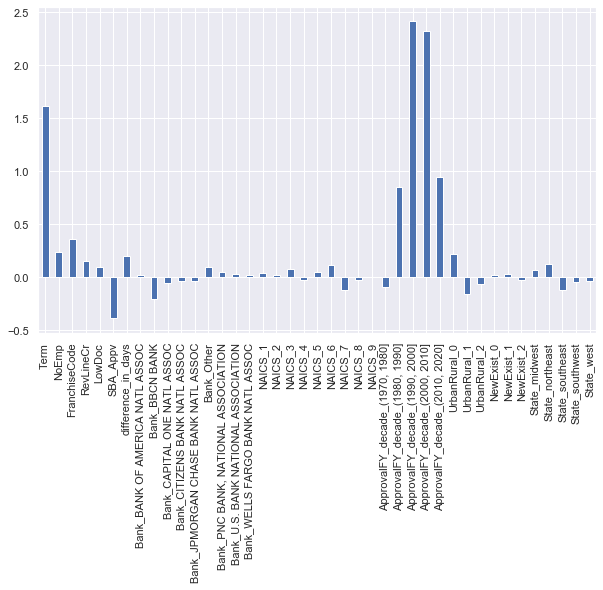

In [35]:
# Scaled Data
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Undersampling
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_us, y_us = us.fit_sample(X, y)

#Scale data
std_scl = StandardScaler()
model = Pipeline([('scale', std_scl),('logit_model',lr_clf)])

cross_validate(model,explanatory.columns, X_us, y_us,scale = True,classifier = 'logit_model')

Another inital Logositic Regression model was created to see if the use of princial components improved model metrics.  PCA allows for all continuous features to be captured and best represented by the optimal number of principal components selected by the algorithm.  The "PCA Features" section determined that the ideal number of principal components for the continuous features were two.  The first two principal components were then incorperated into the feature sapce by first removing the explanatory features used to generate the principal components, then appending the first two principal components.

The new PCA data frame was then undersampled, to allow for equal representation between both majority and minority classes.  Doing so will allow for a model to better predict for both classes in the target feature.  When we look at the confusion matrix of the inital logistic model with no transformations or sampling, the minorty class was barely detected compared to the majority class.

In [36]:
#Principal Components
# Create feature space and target for PCA data
explanatory2 = loans.drop(['MIS_Status','LoanNr_ChkDgt','Name','City','Zip','BankState','ApprovalDate',
                           'ChgOffDate', 'DisbursementDate', 'CreateJob', 'NoEmp','Term','DisbursementGross',
                           'ChgOffPrinGr','GrAppv','SBA_Appv','RetainedJob','difference_in_days'],axis = 1)
#append PCA to dataframe, create a variable that contains feature names, and convert the new dataframe to a matrix
pca_data = pd.concat([explanatory2,prin_com],axis = 1)
names_pca = np.append(explanatory2.columns,["PC1", "PC2"])
X_pca = pca_data.values

#Undersampling
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_us_pca, y_us_pca = us.fit_sample(X_pca, y)

After running this iteration of the model, the Scaled model metrics outpreformed the PCA model.  The scaled model outpreformed the PCA by 6% for the F1-score.

**Scaled Logistic**   
Mean f1-score: 0.7668731353724914  
CV Time:  27.47424626350403  

**PCA Logistic**  
Mean f1-score: 0.7089302574135864  
CV Time:  17.88956570625305  

The Scaled logistic model will be used for prediciton and its hyper-parameters will be tunned to optimize to improve the model metrics.

====Iteration 1  ====
f1-score 0.7065063416241146

confusion matrix
 [[24350  7366]
 [10452 21446]]

====Iteration 2  ====
f1-score 0.710523270232289

confusion matrix
 [[24617  7293]
 [10216 21488]]

====Iteration 3  ====
f1-score 0.7092494376118618

confusion matrix
 [[24310  7509]
 [10198 21597]]

====Iteration 4  ====
f1-score 0.7078559738134207

confusion matrix
 [[24139  7531]
 [10319 21625]]

====Iteration 5  ====
f1-score 0.7105492159921188

confusion matrix
 [[24347  7483]
 [10146 21638]]

--------------------------------
Mean f1-score: 0.7089368478547609
CV Time:  14.824296951293945


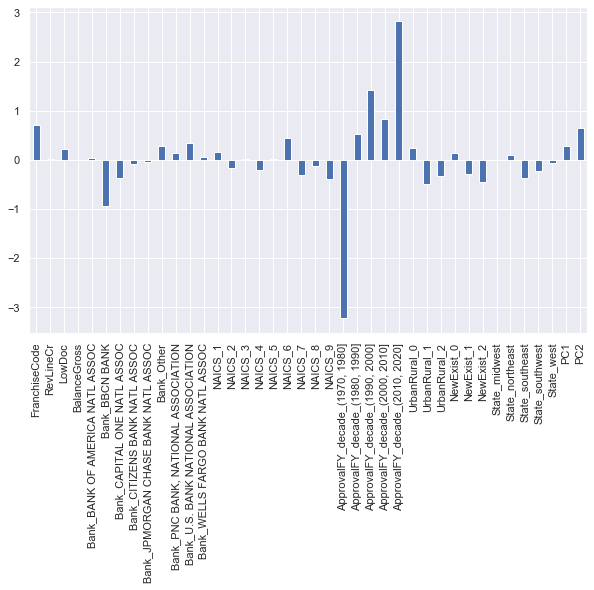

In [37]:
#Run model with undersampled data
lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None, solver='liblinear', random_state=42)
cross_validate(model = lr_clf,feature_names = names_pca,X = X_us_pca,y = y_us_pca, scale = False,classifier = 'logit_model')

## Logistic Model Refinement

Features with small weights from the scaled features for the logistic model were removed prior to preforming GridSearchCV().  These features identified and removed by visualy inspecting the features and removing features with weights less than 0.15.  Removing excess features helps reduce overfitting. Ten features were removed using this process, where 31 features remain.

The new logistic model with reduced features had an F1-score that was very close to the original logistic model with scaled features.  This suggests that the features removed did not contribute very much to the model.

The confusion matrix for the refined model shows that undersampling on the majority class has allowed the minority class to be equally represented.  Undersample improves the model's ability to detect the minority class.

**Scaled Logistic**  
Mean f1-score: 0.7668413414478861

**Refined Scaled Logistic**  
Mean f1-score: 0.7663960144427988

====Iteration 1  ====
f1-score 0.7667885255080196

confusion matrix
 [[26170  5546]
 [ 8616 23282]]

====Iteration 2  ====
f1-score 0.7671065048591911

confusion matrix
 [[26380  5530]
 [ 8537 23167]]

====Iteration 3  ====
f1-score 0.7660990151190751

confusion matrix
 [[26154  5665]
 [ 8537 23258]]

====Iteration 4  ====
f1-score 0.7658576582486061

confusion matrix
 [[25985  5685]
 [ 8593 23351]]

====Iteration 5  ====
f1-score 0.7661283684791019

confusion matrix
 [[26137  5693]
 [ 8514 23270]]

--------------------------------
Mean f1-score: 0.7663960144427988
CV Time:  23.515650749206543


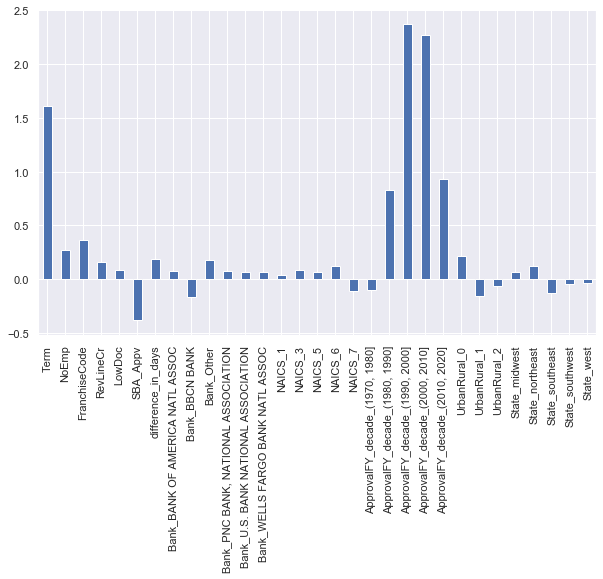

In [38]:
#initalize logistic regression
lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None, solver='liblinear', random_state=42)

#create data frame with features that have weights that contribute most and convert to matrix
explanatory_improved = explanatory.drop(['Bank_CAPITAL ONE NATL ASSOC','Bank_CITIZENS BANK NATL ASSOC', 
                                         'Bank_JPMORGAN CHASE BANK NATL ASSOC', 'NAICS_2','NAICS_4','NAICS_8',
                                         'NAICS_9','NewExist_0', 'NewExist_1','NewExist_2'],axis = 1)
X2 = explanatory_improved.values

#Undersample majority class to improve representation of minority class
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_us2, y_us2 = us.fit_sample(X2, y)

#Scale data
std_scl = StandardScaler()
model2 = Pipeline([('scale', std_scl),('logit_model',lr_clf)])

#Cross Validate
cross_validate(model = model2 ,feature_names = explanatory_improved.columns,X = X_us2,y = y_us2, scale = True,classifier = 'logit_model')

### Logistic Regression Hyper-parameter Tunning

After the intial cross-validation, logistic regression, and parameter objects were defined they were inserted into the GridSearchCV() funciton.  This function exhaustively searches accross defined parameters to select the best values for those parameters and maximizes the model performance metric of choice as defined in the "refit" argument of the funciton.

The cost parameter is the inverse of regularization strength with a range of 0 to infinity.  Values closer to 0 are at greater risk for over fitting, whereas larger values are at risk for under-fitting. 

F1-Score will be used to judge model preformance as it is a harmonic mean between precision and recall, or a ratio between the positive predictive value and the true positive rate.  This preformance metric can help describe how well a model is at identifying the correct response classes.

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
C = np.logspace(0, 4, 12)
param_grid = [{'logit_model__C': C}]
scoring = {'f1': make_scorer(f1_score)}

In [40]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(model2, param_grid, cv=cv, scoring = scoring, refit = 'f1', return_train_score = True)

# Fit grid search
start = time.time()
grid_search = clf.fit(X_us2, y_us2)
elapsed_time = (time.time() - start)

After the grid search was complete and data was fit to the parameters selected by that function; the F1-score, the best parameter value, and a confusion matrix were output to help judge the preformance of the new model with tunned hyper-parameters.  The F1-score from the grid search cross validated model was marginally better than the refined model:

**GridSearchCV Logistic**  
Scaled F1-Score:  0.7670733373807981

**Refined Scaled Logistic**  
Mean f1-score: 0.7663960144427988

This model benifitted from the grid search, but only maginally.  The cost value selected by GridSearchCV() was 1873.82.  This value is very lage and suggests that there is weaker regularization; this could potentially suggest that the model us underfit, however the f1-score shows that the preformance is slightly better than the scaled logistic regression.

In [41]:
best_score_f1 = grid_search.best_score_
best_params_f1 = grid_search.best_params_
best_estimator_f1 = grid_search.best_estimator_

print('Scaled F1-Score: ', best_score_f1)
print('Best Cost value: ', best_params_f1)
print('Total Grid Search Results: ', len(grid_search.cv_results_['params']))
print('GridSearchCV Elapsed Time', elapsed_time)

y_hat = best_estimator_f1.predict(X_us2)
print("\nconfusion matrix\n",mt.confusion_matrix(y_us2,y_hat))

Scaled F1-Score:  0.7670733373807981
Best Cost value:  {'logit_model__C': 1873.817422860385}
Total Grid Search Results:  12
GridSearchCV Elapsed Time 232.03010034561157

confusion matrix
 [[131181  27854]
 [ 42749 116286]]


## SVM/SGD Initial Model

### SGD plus Grid Search Undesampled data with PCA
Due to the very large size of the dataset, 899K records, it was necessary to train the model using SGD ratherr than SVM. Two different variations of the cleaned and processed data were used. The first version used employs PCA for all the continuous variables. Since scaling is part of the PCA process it was not necessary to scale this data prior to running the model. Also, it was necessary to balance the results of the data. The model is attempting to predict the results of an unbalanced data set. Only one sixth of small business loans default, fortunately. To train the model it was necessary to sub sample the data so it has an equal number of defaulted and paid in full loans.

Training the hyperparameters involved using a "gridsearchCV" function. Initally very wide parameters were used in the "gridsearchCV". A more refined set of parameters were implemented based on the results obtained with the intial grid search. Every effort was made to "bracket" the parameters so that an optimal solution was not missed because it was not tested for.

In [42]:
# No need to use pipeline to scale. All inputs either categorical or PCA which is already scaled
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier

# Inital hyperparameter array used
# orderMagVals = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1]

# refined hyperparameter arrays
l1_ratio_vals = np.arange(.6, 1.0, .2)

alpha_vals = np.arange(.00009, .00015, .00002)

iterations = 5

param_grid = [{'loss': ['hinge'], 'alpha':alpha_vals, 'l1_ratio':l1_ratio_vals},
             {'loss': ['squared_hinge'], 'alpha':alpha_vals, 'l1_ratio':l1_ratio_vals},
             {'loss': ['perceptron'], 'alpha':alpha_vals, 'l1_ratio':l1_ratio_vals}]

scoring = {'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

start = time.time()

gs_f1_pca = GridSearchCV(estimator = SGDClassifier(penalty='elasticnet', learning_rate='optimal',n_iter_no_change=iterations, random_state = 402),
                            param_grid=param_grid,
                            scoring=scoring,
                            cv = 5, n_jobs=-1, verbose=1, refit='f1', return_train_score=True)

gs_f1_pca.fit(X_us_pca, y_us_pca)

elapsed_time_sgd_pca = (time.time() - start)

# capture all the outputs of the GridSearch
cv_results_f1_pca = gs_f1_pca.cv_results_
best_estimator_f1_pca = gs_f1_pca.best_estimator_
best_index_f1_pca = gs_f1_pca.best_index_
best_score_f1_pca = gs_f1_pca.best_score_
best_params_f1_pca = gs_f1_pca.best_params_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.5min finished


#### Results of SGD PCA
The results of the SGD hyper parameter tuned SGD model are below. The f1 score was used to calculate the "best" fit. Of particular interest is the confusion matrix. We can see from it that the majority of failed and successful loans are predicted. A total of 315 fits of the data were performed and it takes 98 secods to accomplish this. This averages out to slightly more than 3 fits per second.

In [43]:
from sklearn.metrics import confusion_matrix

print('The best f1 score obtained was :', best_score_f1_pca)
print('The best tuned hyperparameters used were :', best_params_f1_pca)
y_hat_f1_pca = best_estimator_f1_pca.predict(X_us_pca)
cmf1_pca = confusion_matrix(y_us_pca,y_hat_f1_pca)
print(cmf1_pca)
print("Time to train the model:", elapsed_time_sgd_pca, " seconds.")


The best f1 score obtained was : 0.6783248233978404
The best tuned hyperparameters used were : {'alpha': 9e-05, 'l1_ratio': 0.6, 'loss': 'hinge'}
[[127683  31352]
 [ 59938  99097]]
Time to train the model: 209.36465501785278  seconds.


### SGD plus Grid Search Undesampled scaled data
The SGD model below was created without using PCA. As such the continuous variables required scaling. The model results in a slightly higher f1 score than the PCA model. Since scaling was needed a pipeline was implemented for the GridSearchCV function. Again, an intial set of hyper parameter tuning values were used and then further refined based upon model performance. The hyper parameter values do bracket the final value as well.

In [44]:
#GridSearch
#orderMagVals = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1]

l1_ratio_vals = np.arange(.6, 0.9, .1)
alpha_vals = np.arange(.001, .002, .0002)

iterations = 5

param_grid = [{'sgd__loss': ['hinge'], 'sgd__alpha':alpha_vals, 'sgd__l1_ratio':l1_ratio_vals},
             {'sgd__loss': ['squared_hinge'], 'sgd__alpha':alpha_vals, 'sgd__l1_ratio':l1_ratio_vals},
             {'sgd__loss': ['perceptron'], 'sgd__alpha':alpha_vals, 'sgd__l1_ratio':l1_ratio_vals}]

scoring = {'Accuracy': make_scorer(accuracy_score),#metrics for measuring preformance
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}
#bundle scaler and model together
pipe = Pipeline([('scaler', StandardScaler()), ('sgd', SGDClassifier(penalty='elasticnet', learning_rate='optimal',n_iter_no_change=iterations, random_state = 402))])

start = time.time()

gs_f1_sc = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid, 
                        scoring=scoring,
                        n_jobs=-1, verbose=1,cv=5, refit='f1', return_train_score=True)

gs_f1_sc.fit(X_us,y_us)

elapsed_time_sgd_sc = (time.time() - start)
#store model metrics in objects
cv_results_f1_sc = gs_f1_sc.cv_results_
best_estimator_f1_sc = gs_f1_sc.best_estimator_
best_index_f1_sc = gs_f1_sc.best_index_
best_score_f1_sc = gs_f1_sc.best_score_
best_params_f1_sc = gs_f1_sc.best_params_



Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.5min finished


#### Results of SGD non-PCA scaled data
The scaled data SGD model returns slightly better results than the PCA data. The best "f1" score for this data is 76%. The scaling process causes this model to only train about 1.5 fits a second

In [45]:

print('The best f1 score obtained was :', best_score_f1_sc)
print('The best tuned hyperparameters used were :', best_params_f1_sc)
y_hat_f1_sc = best_estimator_f1_sc.predict(X_us)
cmf1_sc = confusion_matrix(y_us,y_hat_f1_sc)
print(cmf1_sc)
print("Time to train the model:", elapsed_time_sgd_sc, " seconds.")


The best f1 score obtained was : 0.7628411742201386
The best tuned hyperparameters used were : {'sgd__alpha': 0.0018000000000000004, 'sgd__l1_ratio': 0.8999999999999999, 'sgd__loss': 'hinge'}
[[130529  28506]
 [ 40229 118806]]
Time to train the model: 632.414174079895  seconds.


# Model Advantages

Although both Logistic Regression and SVM are used for classificaiton problems SVM is generally more computationally expensive for larger datasets.  This is due to the need to calculate a hyperplane, via the kernel trick, to separate the target feature into classes.  Because running an SVM is computationally and time intensive; stochastic-gradient decent, batch, or mini-batch techniques are used as faster alternatives for SVM based classification. We chose to use stochastic-gradient decent or SGD.

For classification the trained logistic model is slower than SGD. SGD calculates the cost of a single data point and then recursively updates the weights to minimize the gradient.  When the logistic regression hyper-parameter tunning was preformed the GridSearchCV() for the logistic model took 242.6 seconds - approximately 4 minutesand performed 12 fits. The GridSearch SGD took on previously scaled data performed at a rate of slightly more than 3 fits per second. When scaling data was necessary the SGD model performed at a rate of about 1.5 fits per second. 

Two different sets of data were used to train SGD models. The unscaled data had an "f1" score of 76% and the PCA data had an f1 score of 74%. On that basis the best SGD model was determined to be the one based on the scaled data without principle components. One of the primary disadvantages to the SGD model is the difficulty in explaining model function. The coefficients for a particualr model do not lend themselves to human interpertable results.

The confusion matrices for both models show the majority of predictions fall on the diagonal of true positive and true negative.


As an example the following results were obtained by running SGD on the PCA data:  
**The best f1 score obtained was** : 0.7428256566411604  
**The best tuned hyperparameters used were** : {'alpha': 0.00013000000000000002, 'l1_ratio': 0.8000000000000002, 'loss': 'perceptron'}  
**Confusion Matrix**  
[107952  51083]  
[ 23955 135080]  


As an example the following results were obtained by running SGD on the scaled data:  
**The best f1 score obtained was** : 0.7630555305997041  
**The best tuned hyperparameters used were** : {'sgd__alpha': 0.0014000000000000002, 'sgd__l1_ratio': 0.7999999999999999, 'sgd__loss': 'hinge'}  
**Confusion Matrix**  
[130801  28234]  
[ 41035 118000]  


As an example the following results were obtained by running the refined logistic regression on the scaled data:    
**Scaled F1-Score:**  0.7670733373807981  
**Best Cost value:**  {'logit_model__C': 1873.817422860385}  
**Total Grid Search Results:** 12    
**GridSearchCV Elapsed Time** 243.30484080314636  

*confusion matrix*  
 [[131295  27740]  
 [ 42632 116403]]  

Based on the confusion matricies and the f1-scores for each model above, the logistic regression model with scaled data preformed similaryly to the best SGD model at approximately 76%.

The logistic regression model was choosen to describe the data becuase it provides good predicitons of the data and the elements of the model are useful to explain the impact of the explanatory features.  The ability to see logistic weights also allows for ease of feature selection, where features with smaller weights can be easily removed to reduce over-fitting.

Identifying SVM features, in this case support-vectors, can't be done with the SGD model unless a small sub-sample was taken and an SVM model is run on it.  SGD provides superior training times because this method recursively updates weights accross individual records to move to the lowest gradient.

# Interpret Feature Importance

When visually inspecting the weights for the GridSearchCV() logistic model we can see that: **ApprovalFY_decade** categories with years ranging from 1980-2020, **Term**, and **SBA_Approv** have the larger weights compare to other features in the model.

When interpreting these weights and how they apply to the data and situations in the real world we can say the following:

The length of a loan, or **Term**, can help determine if a loan is more likely to be "paid in full" or a "charge-off."  It is more likely for a shorter-term loan to default and result in a charge-off since shorter term loans have higher payment amounts and interest.  Given the volatility of small businesses and the external factors that could affect them, a shorter term loan would be more difficult for a small business to pay off especially if the small business was affected by additional stress potentially resulting in a charge-off.  The weight for this feature of 1.612 suggests this term is the 3rd most important term in determining if a loan results in the response feature **MIS_Status**.

**SBA_Apprv** is the amount of money approved for a small business loan.  This feature has a slope of -0.38.  The magnitude of this slope suggests that it is the 6th most important feature in determining **MIS_Status**.  If a small business does not have enough revenue, or is affected by a stressor, it is likely that it would be more difficult for a small business to pay off larger loan amounts.
    
**Approval_decade** is a feature that groups loan approval dates by decade.  The weights for the 1990-2000 and 2000-2010 decades are the 1st and 2nd most important terms, the 1980-1990 is the 4th most important term, and 2010-2020 is the 5th most important term by feature weight.  As a group, the **Approval_decade** features contribute a lot in determining **MIS_Status**.  The Dot-Com bust is captured by the loan approvals in the late 1990's and early 2000's and explains the large volume of loans applied in that period.

In [46]:
gs_weights = grid_search.best_estimator_.named_steps["logit_model"].coef_.T 
variable_names = explanatory_improved.columns

for coef, name in zip(gs_weights,variable_names):
    print(name, 'has weight of', coef[0])

Term has weight of 1.6123085407241562
NoEmp has weight of 0.263096628292192
FranchiseCode has weight of 0.36401621269031437
RevLineCr has weight of 0.16449029326604714
LowDoc has weight of 0.08736877073201584
SBA_Appv has weight of -0.38047339989127704
difference_in_days has weight of 0.18939131458041109
Bank_BANK OF AMERICA NATL ASSOC has weight of 0.07515486227890185
Bank_BBCN BANK has weight of -0.16541706459008235
Bank_Other has weight of 0.17972031630517538
Bank_PNC BANK, NATIONAL ASSOCIATION has weight of 0.07397536540958675
Bank_U.S. BANK NATIONAL ASSOCIATION has weight of 0.06889281959201751
Bank_WELLS FARGO BANK NATL ASSOC has weight of 0.06723271346112383
NAICS_1 has weight of 0.03898366945359826
NAICS_3 has weight of 0.08868439040517857
NAICS_5 has weight of 0.06350980311059745
NAICS_6 has weight of 0.11814805563358571
NAICS_7 has weight of -0.10925067753781098
ApprovalFY_decade_(1970, 1980] has weight of 0.10975987491425866
ApprovalFY_decade_(1980, 1990] has weight of 1.495

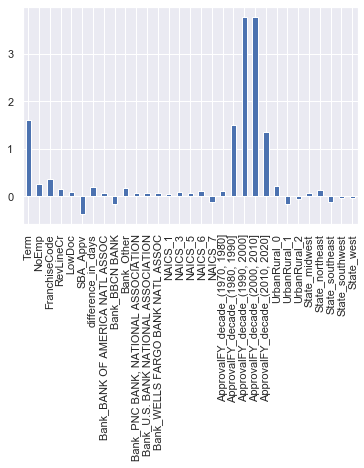

In [47]:
weights = pd.DataFrame(gs_weights,index=variable_names)
weights.plot(kind='bar',legend=None)
plt.show()

# Interpret Support Vectors

SVM tries to find the best margin (the distance between the line and the support vectors). This will separate classes or observations. SVM will uses a classification to determine probability. Standard SVM does not allow you the capability to calibrate posterior to enable post-processing. SVM allows you to train a kernel with a logit link function. In SVM you split data up into training set then you train the parameters the parameters of an additional sigmoid function to map the SVM outputs into probabilities. Support Vector Machines, (SVMs) produce an uncalibrated value that is not a probability. Training an SVM minimizes an error function that penalizes an approximation to the training misclassification rate plus a term that penalizes the norm of h in the RKHS. A diserable goal is to minimize the error function rate in training will also minimize misclassification rate in test. SVM is trained to separate most of all the positive examples from the negative examples, this is fitting probabilities to the output in SVM. We use Gaussians to fit class-condition to the model. Why removed features, we removed and add features to simply fit the model and select a point in our dataset to evaluated it, than perturb one feature at a time through a range of values, whilst keeping the others fixed. We then use this to generate a graph of sensitivity of the model for each feature. One must make sure that the probability=true in the command when initializing and then use clf.predict_proba(X). It is best to sample a collection of relevant points. We are trying to evaluate the model by classifying data without purely relying on F1 score. Another procedure we use is to employed and assign higher weights in the objective function for misclassification of minority examples. This is supposed to ‘incentivise’ the algorithm to correctly classify minority classes. This was used with SVM in conjunction with train/test split.

This paragraph references the following [article](https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e)


In [48]:
features = ['Term','SBA_Appv','ApprovalFY_decade_(1980, 1990]', 'ApprovalFY_decade_(1990, 2000]',
            'ApprovalFY_decade_(2000, 2010]','ApprovalFY_decade_(2010, 2020]']
explanatory_improved_svm = explanatory_improved[features]
names_svm = explanatory_improved_svm.columns
X3 = explanatory_improved_svm.values

Training and testing for the SVM was preformed with scaled data.  The final graphs were created using unscaled data for interpretability with the support vectors.  The SVM model was run on a smaller sample for expediency and to derive support vector values.  Support vector values were then plotted.

In [49]:
cv_object = ShuffleSplit(n_splits=3,test_size  = 0.2)
scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X3,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X3[train_indices]
    y_train = y[train_indices]
    
    X_test = X3[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train) 
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

(586, 6)
(586,)
[292 294]
[[ 1.22144658 -0.15950949  0.19871723  1.66203881  0.8829327   0.50932194]]


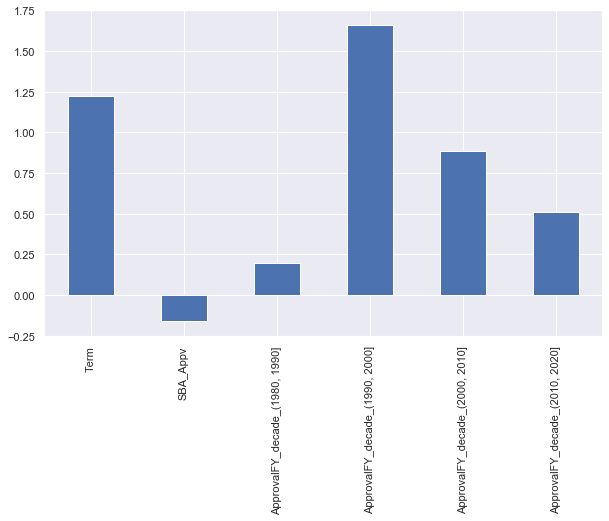

In [50]:
from sklearn.svm import SVC

sampling_strategy = {0:500,1:500}
#sampling_strategy = {0:20,1:20}
mini = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state=402)
X_mini, y_mini = mini.fit_sample(X_train_scaled, y_train)

svmmodel = SVC(kernel = 'linear', C=0.5, degree=3, gamma='auto')
svmmdl = svmmodel.fit(X_mini, y_mini)

print(svmmdl.support_vectors_.shape)
print(svmmdl.support_.shape)
print(svmmdl.n_support_ )
print(svmmdl.coef_)

weights = pd.Series(svmmdl.coef_[0],index=names_svm)
plt.figure(figsize=(10,6))
weights.plot(kind='bar')


In order to compare the support vectors to the original data, a copy of the un-scaled data was created.  Support vectors were then placed over the un-treated data for comparison in the visual below.  The .info() function was run to make sure ensure that the data was copied over correctly.

In [51]:
# grab rows that were selected as support vectors
df = pd.DataFrame(X_mini)
df.columns = names_svm
# make a dataframe of the training data

df_tested_on = explanatory_improved_svm.iloc[train_indices].copy()
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svmmdl.support_,:].copy()

df_support['MIS_status'] = y_mini[svmmdl.support_] # add back in the 'Survived' Column to the pandas dataframe
explanatory_improved_svm['MIS_status'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 282380 to 448293
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Term                            586 non-null    int64  
 1   SBA_Appv                        586 non-null    float64
 2   ApprovalFY_decade_(1980, 1990]  586 non-null    uint8  
 3   ApprovalFY_decade_(1990, 2000]  586 non-null    uint8  
 4   ApprovalFY_decade_(2000, 2010]  586 non-null    uint8  
 5   ApprovalFY_decade_(2010, 2020]  586 non-null    uint8  
 6   MIS_status                      586 non-null    int64  
dtypes: float64(1), int64(2), uint8(4)
memory usage: 20.6 KB


C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


The "term" variable had support vectors at 84 months and 240 months. These are both very common values for term in our data set. 84 month or seven year loan terms are the most common. 240 month or 20 year loans occur often as well. The SBA_approv graphs show that the loan value of \\$100k is the chosen support vector. During exploratory data analysis it was determined that \\$100k was the median value of loans given by the small business administration. Higher numbers of loan were made with terms of 84 and 240 months and with an SBA apporved value of about \\$100k. It would make sense that since more loans are made with these attributes that more mismatches can occur.


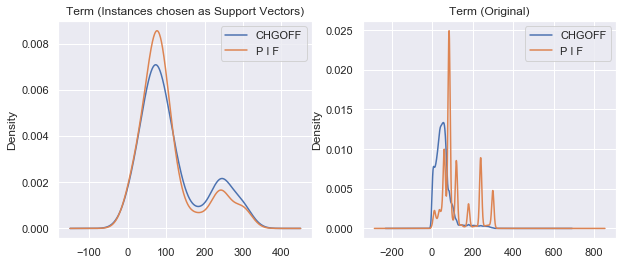

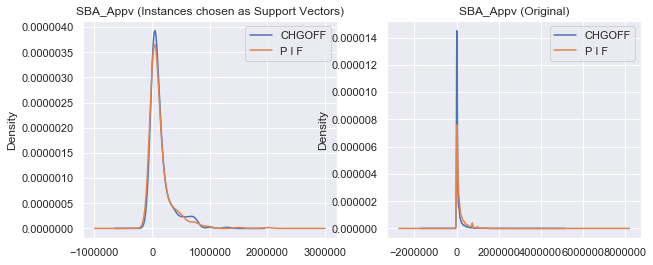

In [52]:
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['MIS_status'])
df_grouped = explanatory_improved_svm.groupby(['MIS_status'])

# plot KDE of Different variables
vars_to_plot = ['Term','SBA_Appv']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['CHGOFF','P I F'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['CHGOFF','P I F'])
    plt.title(v+' (Original)')

# Exceptional Work

We would like to have the following considered for exceptional work:
1. Adaptating the cross_validate() helper function shown in class to include model metrics and the mean feature weight charts
2. gridSearchCV() for hyperparameter tunning
3. The use of Pipelines to combine scaling with a model and it ability to work with the cross_validate() helper function